In [1]:
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
from dem_stitcher.geojson_io import read_geojson_gzip, to_geojson_gzip
from shapely.geometry import Polygon, shape
import asf_search as asf
import concurrent.futures
from tqdm import tqdm
import mpire
import backoff
import requests
import contextily as cx

In [2]:
START_DATE = '2020-10-01'
END_DATE = '2022-12-01'
MINIMUM_SAMPLES_PER_SITE_AND_BURST = 90 # for prior to December 21, 2021 we expect ~60 samples per year; after we expect 30
N_TROPICAL_SITES = 10
TROPICAL_BUFFER_DEG = 5

# Read the disturbance Data

In [3]:
df_dist_hls_val = pd.read_csv('https://raw.githubusercontent.com/OPERA-Cal-Val/DIST-Validation/main/referenceTimeSeries_last.csv')
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


# Extracting "change" and Last observed "no change" indices

In [4]:
def get_index(data: list[str], val: str) -> int:
    try:
        ind = data.index(val)
    except ValueError:
        ind = len(data)
    return ind


def get_first_change(labeled_ts):
    get_index_p = lambda val: get_index(labeled_ts, val)
    indices = list(map(get_index_p, ['VLmin', 'VLmaj', 'OCmin', 'OCmaj']))
    ind = min(indices)
    ind = ind if ind < len(labeled_ts) else -1
    return ind

def get_last_noChange(labeled_ts, change_ind):
    if change_ind == -1:
        return -1
    labeled_ts_r = (labeled_ts[:change_ind][::-1])
    ind_nc_r = get_index(labeled_ts_r, 'noChange')
    ind_nc = change_ind - ind_nc_r - 1
    return ind_nc

Debugging/testing

In [5]:
IND_T = 2
row_data = list(df_dist_hls_val.iloc[IND_T])
ts_labeled = row_data[5:]
ind_c = get_first_change(ts_labeled)
ts_labeled[max(ind_c-10, 0): ind_c+10], ind_c

(['noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin'],
 119)

In [6]:
ind_nc = get_last_noChange(ts_labeled, ind_c)
ts_labeled[max(ind_nc, 0) : ind_c+ 1], ind_c

(['noChange',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin'],
 119)

## Extract dates from Table

In [7]:
def get_first_change_from_row(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        change_date = dates[ind_c]
    else:
        change_date = pd.NaT
    return change_date

def get_last_obs_date_before_change(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        ind_nc = get_last_noChange(labeled_ts, ind_c)
        last_obs_date = dates[ind_nc] if ind_nc > -1 else pd.NaT
    else:
        last_obs_date = pd.NaT

    return last_obs_date


In [8]:
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


In [9]:
change_times = df_dist_hls_val.apply(get_first_change_from_row, axis=1)
last_obs_times = df_dist_hls_val.apply(get_last_obs_date_before_change, axis=1)
change_labels = df_dist_hls_val.overallLabel[:10]
print(list(zip(change_times,last_obs_times, change_times > last_obs_times ,change_labels)))

[(Timestamp('2021-10-08 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2022-01-28 00:00:00'), Timestamp('2022-01-06 00:00:00'), True, 'VLmin'), (Timestamp('2021-11-07 00:00:00'), Timestamp('2021-11-02 00:00:00'), True, 'VLmaj'), (Timestamp('2022-05-18 00:00:00'), Timestamp('2022-05-11 00:00:00'), True, 'VLmaj'), (Timestamp('2021-10-03 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2021-11-12 00:00:00'), Timestamp('2021-11-03 00:00:00'), True, 'OCmin'), (NaT, NaT, False, 'noChange'), (NaT, NaT, False, 'noChange')]


In [10]:
df_sites = gpd.GeoDataFrame({'site_id': df_dist_hls_val.ID,
                             'change_label': df_dist_hls_val.overallLabel,
                             'change_type': df_dist_hls_val.changetype,
                             'change_time': change_times,
                             'last_observation_time': last_obs_times},
                             geometry=gpd.points_from_xy(df_dist_hls_val.Long,
                                                         df_dist_hls_val.Lat),
                            crs=CRS.from_epsg(4326))

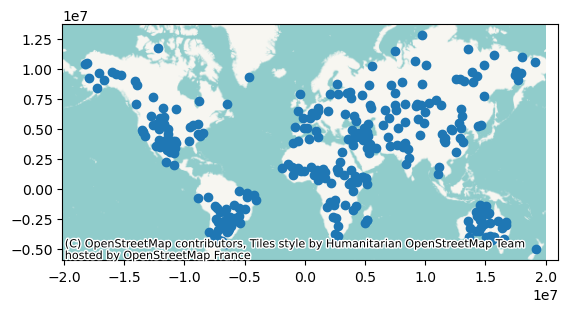

In [11]:
ax = df_sites.to_crs(epsg=3857).plot()
cx.add_basemap(ax)

In [12]:
df_sites.head()

,site_id,change_label,change_type,change_time,last_observation_time,geometry
0,1,VLmaj,Natural browning,2021-10-08,NaT,POINT (-52.37979 -23.29715)
1,2,noChange,No Change,NaT,NaT,POINT (129.85033 -29.57724)
2,3,VLmin,Natural browning,2022-01-28,2022-01-06,POINT (-98.60056 33.771)
3,4,VLmaj,Fire,2021-11-07,2021-11-02,POINT (19.33289 4.5749)
4,5,VLmaj,Fire,2022-05-18,2022-05-11,POINT (115.61901 63.10809)


In [13]:
df_sites_meta = pd.read_csv('https://raw.githubusercontent.com/OPERA-Cal-Val/DIST-Validation/main/sampledpixels1214.csv')
df_sites_meta = df_sites_meta[['ID', 'MGRS']].copy()
df_sites_meta.rename(columns={'ID': 'site_id', 'MGRS': 'mgrs_tile_id'}, inplace=True)
df_sites = pd.merge(df_sites, df_sites_meta, on='site_id')
df_sites.head()

,site_id,change_label,change_type,change_time,last_observation_time,geometry,mgrs_tile_id
0,1,VLmaj,Natural browning,2021-10-08,NaT,POINT (-52.37979 -23.29715),22KCV
1,2,noChange,No Change,NaT,NaT,POINT (129.85033 -29.57724),52JEN
2,3,VLmin,Natural browning,2022-01-28,2022-01-06,POINT (-98.60056 33.771),14SNC
3,4,VLmaj,Fire,2021-11-07,2021-11-02,POINT (19.33289 4.5749),34NCL
4,5,VLmaj,Fire,2022-05-18,2022-05-11,POINT (115.61901 63.10809),50VMR


In [14]:
df_sites.to_file('dist_hls_val_sites.geojson', driver='GeoJSON')

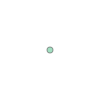

In [15]:
site_lut = df_sites[['site_id', 'geometry']].set_index('site_id').to_dict()
site_lut['geometry'][1]

# Burst Ids

In [18]:
df_burst = read_geojson_gzip('../0_download_burst_data//opera_burst_ids.geojson.zip')
df_burst.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((2.5319 4.75701, 3.29631 4.91201, 3.2...",t001_000025_iw1,1,False,ASCENDING
1,"POLYGON ((3.25912 4.9746, 4.06055 5.13657, 4.0...",t001_000025_iw2,1,False,ASCENDING
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING


# Join Burst table and the site ids

Via a spatial join

In [343]:
df_val_bursts = gpd.sjoin(df_burst, df_sites, how='inner', predicate='intersects').reset_index(drop=True)
df_val_bursts = df_val_bursts.drop_duplicates()
df_val_bursts = df_val_bursts.drop(columns=['index_right'])
df_val_bursts['track_number'] = df_val_bursts.burst_id_jpl.map(lambda burst_id_jpl: int(burst_id_jpl.split('_')[0][1:]))
df_val_bursts = df_val_bursts.sort_values(by=['site_id', 'burst_id_jpl']).reset_index(drop=True)
df_val_bursts.rename(columns={'burst_id_jpl': 'jpl_burst_id'}, inplace=True)
df_val_bursts['jpl_burst_id'] = df_val_bursts['jpl_burst_id'].str.upper().str.replace('_', '-')
df_val_bursts.head()

,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,track_number
0,"POLYGON ((-52.73133 -23.43816, -51.90414 -23.2...",T090-193169-IW1,1,False,ASCENDING,1,VLmaj,Natural browning,2021-10-08,NaT,22KCV,90
1,"POLYGON ((-51.66339 -23.30842, -52.52125 -23.1...",T097-207419-IW2,1,False,DESCENDING,1,VLmaj,Natural browning,2021-10-08,NaT,22KCV,97
2,"POLYGON ((-53.01716 -23.54912, -52.25936 -23.3...",T163-349964-IW3,1,False,ASCENDING,1,VLmaj,Natural browning,2021-10-08,NaT,22KCV,163
3,"POLYGON ((129.8254 -29.63759, 130.62076 -29.44...",T039-083584-IW3,1,False,ASCENDING,2,noChange,No Change,NaT,NaT,52JEN,39
4,"POLYGON ((130.4964 -29.60892, 129.63063 -29.40...",T075-160202-IW1,1,False,DESCENDING,2,noChange,No Change,NaT,NaT,52JEN,75


In [344]:
df_val_bursts.shape

(1117, 12)

<Axes: >

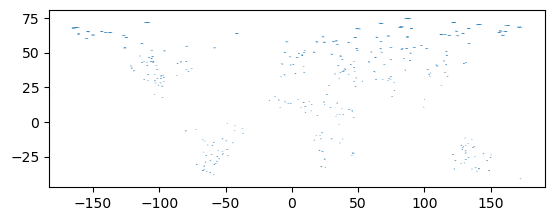

In [345]:
df_val_bursts.plot()

Serializing all the bursts.

In [346]:
#df_val_bursts.to_file('dist_val_bursts.geojson', driver='GeoJSON')

# Multiple bursts overlapping

This is particlarly present at high latitudes. We see multiple tracks overlap. We see that there are 11 distinct bursts overlapping site 80!

In [347]:
df_burst_count = df_val_bursts[['site_id', 'orbit_pass']].groupby('site_id').count().sort_values(by='orbit_pass', ascending=False).reset_index(drop=False)
df_burst_count.head(10)

,site_id,orbit_pass
0,80,11
1,36,10
2,49,9
3,85,9
4,45,9
5,157,9
6,39,8
7,81,8
8,182,8
9,44,8


<Axes: >

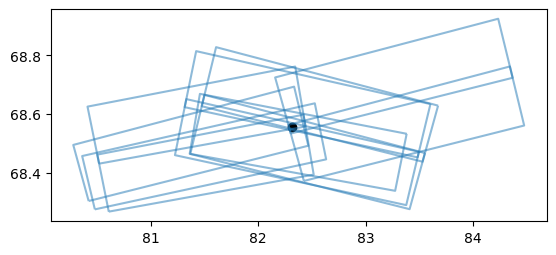

In [348]:
fig, ax = plt.subplots()
df_site = df_sites[df_sites.site_id == 80].plot(ax=ax, color='black')
df_val_bursts[df_val_bursts.site_id == 80].exterior.plot(ax=ax, alpha=.5)

We can better select a suitable burst by calculating the distance from the burst centroid to the Site. This helps find bursts that will likely give us as much context about the site as possible.

In [349]:
def distance_to_site_burst(row):
    poly_cent = row['geometry'].centroid
    site_id = row['site_id']
    site_geo = site_lut['geometry'][site_id]

    dist = site_geo.distance(poly_cent)
    return dist

def distance_to_site_burst_2(row):
    poly_exterior = row['geometry'].exterior
    site_id = row['site_id']
    site_geo = site_lut['geometry'][site_id]

    dist = poly_exterior.distance(site_geo)
    return dist

The sorting of the data

In [350]:
df_val_bursts_ORIGINAL = df_val_bursts.copy()
df_val_bursts_ORIGINAL['dist_from_site_to_burst_centroid'] = df_val_bursts_ORIGINAL.apply(distance_to_site_burst, axis=1)
df_val_bursts_ORIGINAL.sort_values(by=['site_id', 'orbit_pass','dist_from_site_to_burst_centroid'], inplace=True, ascending=True)

In [351]:
df_val_bursts_v2 = df_val_bursts.copy()
df_val_bursts_v2['dist_from_site_to_burst_centroid'] = df_val_bursts_v2.apply(distance_to_site_burst_2, axis=1)
df_val_bursts_v2.sort_values(by=['site_id', 'orbit_pass','dist_from_site_to_burst_centroid'], inplace=True, ascending=False)

In [352]:
# df_val_bursts['dist_from_site_to_burst_centroid'] = df_val_bursts.apply(distance_to_site_burst, axis=1)
# df_val_bursts.sort_values(by=['site_id', 'orbit_pass','dist_from_site_to_burst_centroid'], inplace=True)

## Get only 1 bursts from ASC/DSC

Since the data is now ordered by its proximity to the site, we can select the topmost entry in each group of `site_id` and `orbit_pass` (i.e. ascending/descending).

In [355]:
df_val_bursts_filtered_original = df_val_bursts_ORIGINAL.groupby(['site_id', 'orbit_pass']).head(1).reset_index(drop=True)
df_val_bursts_filtered_original.shape, df_val_bursts.shape

((600, 13), (1117, 12))

In [358]:
df_val_bursts_filtered_v2 = df_val_bursts_v2.groupby(['site_id', 'orbit_pass']).head(1).reset_index(drop=True)
df_val_bursts_filtered_v2.shape, df_val_bursts.shape

((600, 13), (1117, 12))

/tmp/ipykernel_124352/2792349925.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_val_bursts_v2[df_val_bursts_v2.site_id == site_id].geometry.centroid.plot(ax=ax, alpha=.5)


<Axes: >

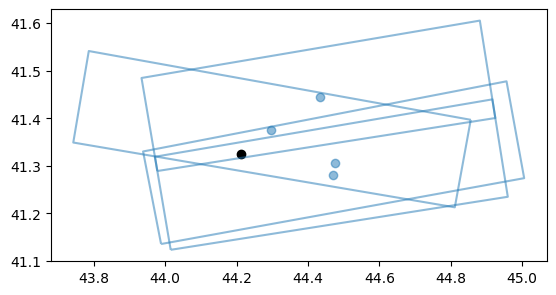

In [387]:
fig, ax = plt.subplots()
site_id = 272#272#148#95#df_sites.site_id.iloc[20]
df_site = df_sites[df_sites.site_id == site_id].plot(ax=ax, color='black')
df_val_bursts_v2[df_val_bursts_v2.site_id == site_id].exterior.plot(ax=ax, alpha=.5)
df_val_bursts_v2[df_val_bursts_v2.site_id == site_id].geometry.centroid.plot(ax=ax, alpha=.5)

/tmp/ipykernel_124352/3836352676.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_val_bursts_filtered_original[df_val_bursts_filtered_original.site_id == site_id].geometry.centroid.plot(ax=ax, alpha=.5)


<Axes: >

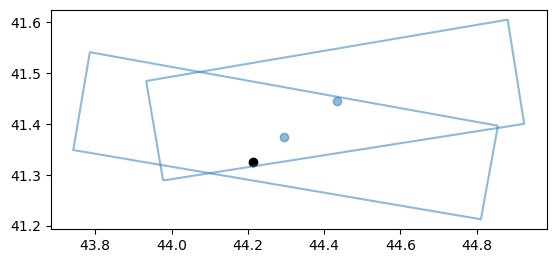

In [388]:
fig, ax = plt.subplots()
df_site = df_sites[df_sites.site_id == site_id].plot(ax=ax, color='black')
df_val_bursts_filtered_original[df_val_bursts_filtered_original.site_id == site_id].exterior.plot(ax=ax, alpha=.5)
df_val_bursts_filtered_original[df_val_bursts_filtered_original.site_id == site_id].geometry.centroid.plot(ax=ax, alpha=.5)

/tmp/ipykernel_124352/2447612544.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_val_bursts_filtered_v2[df_val_bursts_filtered_v2.site_id == site_id].geometry.centroid.plot(ax=ax, alpha=.5)


<Axes: >

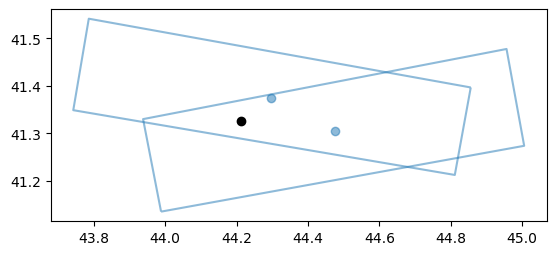

In [389]:
fig, ax = plt.subplots()
df_site = df_sites[df_sites.site_id == site_id].plot(ax=ax, color='black')
df_val_bursts_filtered_v2[df_val_bursts_filtered_v2.site_id == site_id].exterior.plot(ax=ax, alpha=.5)
df_val_bursts_filtered_v2[df_val_bursts_filtered_v2.site_id == site_id].geometry.centroid.plot(ax=ax, alpha=.5)

In [361]:
df_val_bursts_filtered_v2.head()

,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,track_number,dist_from_site_to_burst_centroid
0,"POLYGON ((25.13287 12.70586, 24.35475 12.86352...",T138-295267-IW1,1,False,DESCENDING,300,noChange,No Change,NaT,NaT,35PKQ,138,0.082113
1,"POLYGON ((24.35053 12.50287, 25.16886 12.65743...",T073-154721-IW2,1,False,ASCENDING,300,noChange,No Change,NaT,NaT,35PKQ,73,0.055405
2,"POLYGON ((-102.95044 29.68126, -103.82858 29.8...",T085-181325-IW1,1,True,DESCENDING,299,noChange,No Change,NaT,NaT,13RFN,85,0.071135
3,"POLYGON ((-103.68544 29.47074, -102.87003 29.5...",T151-322360-IW3,1,True,ASCENDING,299,noChange,No Change,NaT,NaT,13RFN,151,0.058082
4,"POLYGON ((-47.82303 -24.31718, -48.68781 -24.1...",T126-269715-IW2,1,False,DESCENDING,298,noChange,No Change,NaT,NaT,22KGU,126,0.018924


In [362]:
df_val_bursts_filtered_v2.columns

Index(['geometry', 'jpl_burst_id', 'is_land', 'is_north_america', 'orbit_pass',
       'site_id', 'change_label', 'change_type', 'change_time',
       'last_observation_time', 'mgrs_tile_id', 'track_number',
       'dist_from_site_to_burst_centroid'],
      dtype='object')

In [364]:
df_val_bursts_DOWNSELECTED_V1 = df_val_bursts_filtered_original[['jpl_burst_id', 'site_id', 'orbit_pass', 'track_number', 'geometry']].copy()

In [365]:
df_val_bursts_DOWNSELECTED_CURRENT = df_val_bursts_filtered_v2[['jpl_burst_id', 'site_id', 'orbit_pass', 'track_number', 'geometry']].copy()

In [366]:
df_val_bursts_DOWNSELECTED_CURRENT.to_parquet('validation_bursts_all_v2.parquet')
df_val_bursts_DOWNSELECTED_V1.to_parquet('validation_bursts_all_v1.parquet')

# Getting SLC IDs

Now that we have the burst for each ascending/descending pass we will use, we query the ASF DAAC for the SLC metadata we need.

In [156]:
@backoff.on_exception(backoff.expo,
                      (requests.exceptions.ReadTimeout,
                       requests.exceptions.ConnectionError,
                      RuntimeError))
def get_asf_results(*,geo: Point,
                    site_id: int,
                    track_number: int,
                    jpl_burst_id: str,
                    **kwargs):
    
    res = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                         intersectsWith=geo.wkt,
                         #maxResults=5_000,
                         polarization=['VV+VH'], # could add just 'VV'
                         beamMode=[asf.BEAMMODE.IW],
                         relativeOrbit=[track_number],
                         processingLevel=[asf.PRODUCT_TYPE.SLC],
                         start=START_DATE,
                         end=END_DATE
                         )
    df_res = pd.DataFrame()
    if res:
        geometry = [shape(r.geojson()['geometry']) for r in res]
        data = [r.properties for r in res]

        df_res = pd.DataFrame(data)
        df_res = gpd.GeoDataFrame(df_res,
                                  geometry=geometry,
                                  crs=CRS.from_epsg(4326))
        df_res['site_id'] = site_id
        df_res['jpl_burst_id'] = jpl_burst_id

    return df_res

def get_asf_results_from_record(record) -> gpd.GeoDataFrame:
    df = get_asf_results(geo=record['geometry'], site_id=record['site_id'], track_number=record['track_number'], jpl_burst_id=record['jpl_burst_id'])
    return df

We want the site point for the query as it's more exact.

In [157]:
df_query = df_val_bursts_DOWNSELECTED_CURRENT.copy()
df_query = df_query.drop(columns=['geometry'])
df_query = pd.merge(df_query, df_sites[['site_id', 'geometry']], how='left', on='site_id')
df_query.shape

(600, 5)

In [158]:
records = df_query.to_dict('records')
records[:2]

[{'jpl_burst_id': 'T138-295267-IW1',
  'site_id': 300,
  'orbit_pass': 'DESCENDING',
  'track_number': 138,
  'geometry': <POINT (24.705 12.709)>},
 {'jpl_burst_id': 'T073-154721-IW2',
  'site_id': 300,
  'orbit_pass': 'ASCENDING',
  'track_number': 73,
  'geometry': <POINT (24.705 12.709)>}]

In [159]:
get_asf_results_from_record(records[4]).head(2)

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType,s3Urls,geometry,site_id,jpl_burst_id
0,-24.0265,-48.1764,2022-11-25T08:40:06Z,S1A_IW_SLC__1SDV_20221125T083939_20221125T0840...,DESCENDING,126,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-11-25T08:39:39Z,S1A_IW_SLC__1SDV_20221125T083939_20221125T0840...,...,2022-11-25T08:39:39Z,C-SAR,S1A_IWDV_0671_0677_046048_126,003.52,S1A_IW_SLC__1SDV_20221125T083939_20221125T0840...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-47.18138 -25.1161, -46.75259 -23.49...",298,T126-269715-IW2
1,-24.0268,-48.1749,2022-11-13T08:40:06Z,S1A_IW_SLC__1SDV_20221113T083939_20221113T0840...,DESCENDING,126,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-11-13T08:39:39Z,S1A_IW_SLC__1SDV_20221113T083939_20221113T0840...,...,2022-11-13T08:39:39Z,C-SAR,S1A_IWDV_0671_0677_045873_126,003.52,S1A_IW_SLC__1SDV_20221113T083939_20221113T0840...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-47.17999 -25.11659, -46.75107 -23.4...",298,T126-269715-IW2


In [160]:
dfs = list(map(get_asf_results_from_record, tqdm(records)))

100%|███████████████████████████████| 600/600 [05:44<00:00,  1.74it/s]


In [161]:
# with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
#     dfs = list(tqdm(executor.map(get_asf_results_from_record, records[:]), total=len(records)))

In [162]:
df_slcs = pd.concat(dfs, axis=0)
df_slcs.head()

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType,s3Urls,geometry,site_id,jpl_burst_id
0,13.3633,24.0663,2022-11-26T04:14:42Z,S1A_IW_SLC__1SDV_20221126T041412_20221126T0414...,DESCENDING,138,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-11-26T04:14:12Z,S1A_IW_SLC__1SDV_20221126T041412_20221126T0414...,...,2022-11-26T04:14:12Z,C-SAR,S1A_IWDV_0547_0553_046060_138,003.52,S1A_IW_SLC__1SDV_20221126T041412_20221126T0414...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((25.01571 12.24027, 25.38652 14.04356...",300,T138-295267-IW1
1,13.3624,24.0682,2022-11-14T04:14:42Z,S1A_IW_SLC__1SDV_20221114T041412_20221114T0414...,DESCENDING,138,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-11-14T04:14:12Z,S1A_IW_SLC__1SDV_20221114T041412_20221114T0414...,...,2022-11-14T04:14:12Z,C-SAR,S1A_IWDV_0547_0553_045885_138,003.52,S1A_IW_SLC__1SDV_20221114T041412_20221114T0414...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((25.0176 12.23932, 25.38849 14.04285,...",300,T138-295267-IW1
2,13.3627,24.0689,2022-11-02T04:14:42Z,S1A_IW_SLC__1SDV_20221102T041412_20221102T0414...,DESCENDING,138,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-11-02T04:14:12Z,S1A_IW_SLC__1SDV_20221102T041412_20221102T0414...,...,2022-11-02T04:14:12Z,C-SAR,S1A_IWDV_0547_0553_045710_138,003.52,S1A_IW_SLC__1SDV_20221102T041412_20221102T0414...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((25.01831 12.23978, 25.38909 14.04282...",300,T138-295267-IW1
3,13.3626,24.0695,2022-10-21T04:14:42Z,S1A_IW_SLC__1SDV_20221021T041412_20221021T0414...,DESCENDING,138,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-10-21T04:14:12Z,S1A_IW_SLC__1SDV_20221021T041412_20221021T0414...,...,2022-10-21T04:14:12Z,C-SAR,S1A_IWDV_0547_0553_045535_138,003.52,S1A_IW_SLC__1SDV_20221021T041412_20221021T0414...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((25.01891 12.23957, 25.38975 14.04298...",300,T138-295267-IW1
4,13.3627,24.0688,2022-10-09T04:14:42Z,S1A_IW_SLC__1SDV_20221009T041412_20221009T0414...,DESCENDING,138,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-10-09T04:14:12Z,S1A_IW_SLC__1SDV_20221009T041412_20221009T0414...,...,2022-10-09T04:14:12Z,C-SAR,S1A_IWDV_0547_0553_045360_138,003.52,S1A_IW_SLC__1SDV_20221009T041412_20221009T0414...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((25.01826 12.23982, 25.38901 14.04298...",300,T138-295267-IW1


Serialize the asf data and remove the `s3Urls` because they require 

In [167]:
import datetime

today = datetime.date.today()
str(today)

'2024-07-10'

In [341]:
df_slcs.to_parquet(f'slcs_resp_{today}.parquet')

# Filtering the SLC data

First we read the data we have serialized (so we don't have to unnecessarily query ASF).

In [171]:
df_slcs = gpd.read_parquet(f'slcs_resp_{today}.parquet')

Let's first observe there are multiple SLCs for a given pass.

In [172]:
df_slcs['date_acquired_str'] = pd.to_datetime(df_slcs['startTime']).dt.date.map(str)
df_slcs.sort_values(by=['site_id', 'jpl_burst_id', 'date_acquired_str'], inplace=True)

We really only want one SLC for a given burst and date/pass.

In [173]:
df_slcs['date_acquired_str'] = pd.to_datetime(df_slcs['startTime']).dt.date.map(str)
df_slc_per_date_count = df_slcs[['jpl_burst_id', 'date_acquired_str', 'site_id', 'fileID']].groupby(['jpl_burst_id', 'date_acquired_str', 'site_id']).count().sort_values(by='fileID', ascending=False).reset_index(drop=False)
df_slc_per_date_count.iloc[:2]

,jpl_burst_id,date_acquired_str,site_id,fileID
0,T027-056013-IW2,2021-01-27,103,2
1,T027-056013-IW2,2021-01-15,103,2


In [63]:
# df_slcs[df_slcs.jpl_burst_id == 't021_043849_iw2'].head()

There are some sites that actually share bursts/SLCs. An example of two sites with shared burst and 2 SLCs.

In [178]:
BURST_ID = 'T042-088909-IW2'

In [179]:
df_slcs[(df_slcs.jpl_burst_id == BURST_ID) & (df_slcs.date_acquired_str == '2021-08-14')][['site_id', 'jpl_burst_id', 'fileID']]

,site_id,jpl_burst_id,fileID
49,117,T042-088909-IW2,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...
50,117,T042-088909-IW2,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...
49,166,T042-088909-IW2,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...
50,166,T042-088909-IW2,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...


<Axes: >

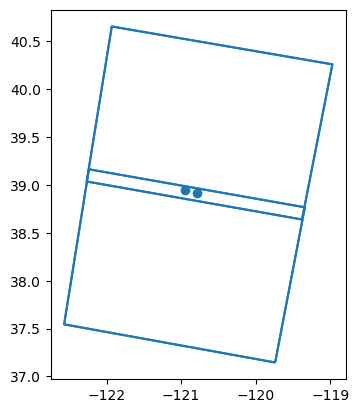

In [180]:
fig, ax = plt.subplots()

df_sites[df_sites.site_id.isin([166, 117])].plot(ax=ax)
df_slcs[(df_slcs.jpl_burst_id == BURST_ID) & (df_slcs.date_acquired_str == '2021-08-14')].exterior.plot(ax=ax)

### Filtering the SLCs by proximity to Site

Again, we can order the SLCs within flight direction (ascending/descending) and site according to the SLCs proximity to the site.

In [182]:
def distance_to_site_slc(row):
    poly_cent = row['geometry'].centroid
    site_id = row['site_id']
    site_geo = site_lut['geometry'][site_id]

    dist = site_geo.distance(poly_cent)
    return dist


def distance_to_site_slc_2(row):
    poly_ext = row['geometry'].exterior
    site_id = row['site_id']
    site_geo = site_lut['geometry'][site_id]

    dist = poly_ext.distance(site_geo)
    return dist

In [212]:
df_slcs['dist_from_site_to_slc_centroid'] = df_slcs.apply(distance_to_site_slc_2, axis=1)
df_slcs[(df_slcs.jpl_burst_id == BURST_ID) & (df_slcs.date_acquired_str == '2021-08-14')]

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,groupID,pgeVersion,fileName,beamModeType,s3Urls,geometry,site_id,jpl_burst_id,date_acquired_str,dist_from_site_to_slc_centroid
49,38.1638,-120.9678,2021-08-14T14:07:41Z,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14T14:07:14Z,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,...,S1B_IWDV_0465_0470_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-119.73837 37.14591, -119.33971 38.7...",166,T042-088909-IW2,2021-08-14,0.037116
50,39.6564,-120.6329,2021-08-14T14:07:16Z,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14T14:06:49Z,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,...,S1B_IWDV_0459_0466_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-119.37796 38.63911, -118.97026 40.2...",166,T042-088909-IW2,2021-08-14,0.093679
49,38.1638,-120.9678,2021-08-14T14:07:41Z,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14T14:07:14Z,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,...,S1B_IWDV_0465_0470_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-119.73837 37.14591, -119.33971 38.7...",117,T042-088909-IW2,2021-08-14,0.050216
50,39.6564,-120.6329,2021-08-14T14:07:16Z,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14T14:06:49Z,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,...,S1B_IWDV_0459_0466_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-119.37796 38.63911, -118.97026 40.2...",117,T042-088909-IW2,2021-08-14,0.080619


In [213]:
df_slcs.sort_values(by=['site_id', 'jpl_burst_id', 'date_acquired_str', 'dist_from_site_to_slc_centroid'], inplace=True, ascending=False)
df_slcs_filtered = df_slcs.groupby(['jpl_burst_id', 'date_acquired_str']).head(1)
df_slcs_filtered.shape

(25544, 30)

In [214]:
print('Total unique SLCs needed: ', len(df_slcs_filtered.fileID.unique()))

Total unique SLCs needed:  24474


In [215]:
df_slcs_filtered.to_dict('records')[0]

{'centerLat': 13.3633,
 'centerLon': 24.0663,
 'stopTime': '2022-11-26T04:14:42Z',
 'fileID': 'S1A_IW_SLC__1SDV_20221126T041412_20221126T041442_046060_058350_3A05-SLC',
 'flightDirection': 'DESCENDING',
 'pathNumber': 138,
 'processingLevel': 'SLC',
 'url': 'https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20221126T041412_20221126T041442_046060_058350_3A05.zip',
 'startTime': '2022-11-26T04:14:12Z',
 'sceneName': 'S1A_IW_SLC__1SDV_20221126T041412_20221126T041442_046060_058350_3A05',
 'browse': None,
 'platform': 'Sentinel-1A',
 'bytes': 4823754859,
 'md5sum': '97a19f55e40edc8fff38c3a0b655fdf9',
 'frameNumber': 547,
 'granuleType': 'SENTINEL_1A_FRAME',
 'orbit': 46060,
 'polarization': 'VV+VH',
 'processingDate': '2022-11-26T04:14:12Z',
 'sensor': 'C-SAR',
 'groupID': 'S1A_IWDV_0547_0553_046060_138',
 'pgeVersion': '003.52',
 'fileName': 'S1A_IW_SLC__1SDV_20221126T041412_20221126T041442_046060_058350_3A05.zip',
 'beamModeType': 'IW',
 's3Urls': array(['s3://asf-ngap2w-p-s1-slc-7b

In [216]:
df_slc_per_site_and_fa = df_slcs_filtered[['site_id', 'flightDirection', 'fileID']].groupby(['site_id', 'flightDirection']).count().sort_values(by='fileID', ascending=False).reset_index(drop=False)
df_slc_per_site_and_fa.head()

,site_id,flightDirection,fileID
0,72,ASCENDING,104
1,22,DESCENDING,104
2,261,DESCENDING,104
3,90,ASCENDING,103
4,224,ASCENDING,103


In [217]:
df_slc_per_site_and_fa.iloc[-4:]

,site_id,flightDirection,fileID
413,239,ASCENDING,1
414,243,DESCENDING,1
415,108,ASCENDING,1
416,125,ASCENDING,1


In [218]:
df_slcs_per_burst_and_site = df_slcs_filtered[['site_id', 'flightDirection', 'fileID', 'jpl_burst_id']].groupby(['site_id', 'jpl_burst_id', 'flightDirection']).size().reset_index(name='slc_count')
df_slcs_per_burst_and_site = df_slcs_per_burst_and_site.sort_values(by='slc_count', ascending=False).reset_index(drop=True)
df_slcs_per_burst_and_site.iloc[:4]

,site_id,jpl_burst_id,flightDirection,slc_count
0,261,T022-045880-IW1,DESCENDING,104
1,22,T021-043823-IW2,DESCENDING,104
2,72,T005-008692-IW2,ASCENDING,104
3,287,T152-325207-IW2,DESCENDING,103


In [219]:
df_slcs_filtered[df_slcs_filtered.site_id == 72].head()

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,groupID,pgeVersion,fileName,beamModeType,s3Urls,geometry,site_id,jpl_burst_id,date_acquired_str,dist_from_site_to_slc_centroid
0,18.3324,-98.3737,2022-09-27T12:27:01Z,S1A_IW_SLC__1SDV_20220927T122634_20220927T1227...,DESCENDING,143,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-09-27T12:26:34Z,S1A_IW_SLC__1SDV_20220927T122634_20220927T1227...,...,S1A_IWDV_0530_0537_045190_143,003.52,S1A_IW_SLC__1SDV_20220927T122634_20220927T1227...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-97.37712 17.30137, -97.03875 18.929...",72,T143-305976-IW1,2022-09-27,0.132740
1,18.3332,-98.3743,2022-08-10T12:26:59Z,S1A_IW_SLC__1SDV_20220810T122632_20220810T1226...,DESCENDING,143,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-08-10T12:26:32Z,S1A_IW_SLC__1SDV_20220810T122632_20220810T1226...,...,S1A_IWDV_0530_0537_044490_143,003.52,S1A_IW_SLC__1SDV_20220810T122632_20220810T1226...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-97.37785 17.30211, -97.03945 18.930...",72,T143-305976-IW1,2022-08-10,0.131877
2,18.3321,-98.3752,2022-06-11T12:26:56Z,S1A_IW_SLC__1SDV_20220611T122629_20220611T1226...,DESCENDING,143,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-06-11T12:26:29Z,S1A_IW_SLC__1SDV_20220611T122629_20220611T1226...,...,S1A_IWDV_0530_0537_043615_143,003.52,S1A_IW_SLC__1SDV_20220611T122629_20220611T1226...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-97.37868 17.30108, -97.0403 18.9296...",72,T143-305976-IW1,2022-06-11,0.131266
3,18.3329,-98.3723,2022-05-18T12:26:54Z,S1A_IW_SLC__1SDV_20220518T122627_20220518T1226...,DESCENDING,143,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-05-18T12:26:27Z,S1A_IW_SLC__1SDV_20220518T122627_20220518T1226...,...,S1A_IWDV_0530_0537_043265_143,003.52,S1A_IW_SLC__1SDV_20220518T122627_20220518T1226...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-97.37565 17.3019, -97.03728 18.9303...",72,T143-305976-IW1,2022-05-18,0.134072
4,18.3333,-98.3719,2022-05-06T12:26:53Z,S1A_IW_SLC__1SDV_20220506T122626_20220506T1226...,DESCENDING,143,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-05-06T12:26:26Z,S1A_IW_SLC__1SDV_20220506T122626_20220506T1226...,...,S1A_IWDV_0530_0537_043090_143,003.51,S1A_IW_SLC__1SDV_20220506T122626_20220506T1226...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-97.37526 17.30228, -97.03686 18.930...",72,T143-305976-IW1,2022-05-06,0.134383


In [220]:
df_slcs_per_burst_and_site.iloc[-4:]

,site_id,jpl_burst_id,flightDirection,slc_count
413,243,T022-046098-IW1,DESCENDING,1
414,282,T086-184581-IW2,ASCENDING,1
415,269,T149-319844-IW1,ASCENDING,1
416,108,T130-277443-IW3,ASCENDING,1


Simply due to S1A/S1B availability, we see that certain bursts have less than the expected number of samples. Filtering by frequency ensure we will have a dense time series.

In [221]:
df_val_bursts_with_count = pd.merge(df_val_bursts_filtered, 
                                   df_slcs_per_burst_and_site[['site_id', 'jpl_burst_id', 'slc_count']], 
                                  on=['site_id','jpl_burst_id'], 
                                  how='left')
# Some bursts have no counts and are therefore NA
df_val_bursts_with_count.dropna(axis=0, subset=['slc_count'], inplace=True)
df_val_bursts_with_count.head()

,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,track_number,dist_from_site_to_burst_centroid,slc_count
0,"POLYGON ((25.13287 12.70586, 24.35475 12.86352...",T138-295267-IW1,1,False,DESCENDING,300,noChange,No Change,NaT,NaT,35PKQ,138,0.082113,55.0
2,"POLYGON ((-102.95044 29.68126, -103.82858 29.8...",T085-181325-IW1,1,True,DESCENDING,299,noChange,No Change,NaT,NaT,13RFN,85,0.071135,66.0
3,"POLYGON ((-103.68544 29.47074, -102.87003 29.5...",T151-322360-IW3,1,True,ASCENDING,299,noChange,No Change,NaT,NaT,13RFN,151,0.058082,60.0
4,"POLYGON ((-47.82303 -24.31718, -48.68781 -24.1...",T126-269715-IW2,1,False,DESCENDING,298,noChange,No Change,NaT,NaT,22KGU,126,0.018924,63.0
6,"POLYGON ((-124.47276 61.03441, -126.04566 61.2...",T130-277792-IW1,1,False,DESCENDING,297,VLmaj,Fire,2022-05-21,NaT,10VCN,130,0.099192,37.0


In [222]:
sufficient_sampling_ind = df_val_bursts_with_count.slc_count >= MINIMUM_SAMPLES_PER_SITE_AND_BURST
bursts_with_enough_samples = df_val_bursts_with_count[sufficient_sampling_ind].jpl_burst_id.unique()
print('Total bursts with enough samples: ', (sufficient_sampling_ind).sum())
print('Total bursts available (i.e. with SLCs): ', len(df_val_bursts_with_count.jpl_burst_id.unique()))

Total bursts with enough samples:  87
Total bursts available (i.e. with SLCs):  417


In [223]:
sites_with_enough_samples = df_val_bursts_with_count[sufficient_sampling_ind].site_id.unique().tolist()
print('Total sites with enough samples: ', len(sites_with_enough_samples))
print('Total sites available (i.e. with SLCs): ', len(df_val_bursts_with_count.site_id.unique()))

Total sites with enough samples:  55
Total sites available (i.e. with SLCs):  284


In [224]:
df_val_bursts_tropical = df_val_bursts_with_count.cx[:, -TROPICAL_BUFFER_DEG: TROPICAL_BUFFER_DEG].reset_index(drop=True)
df_val_bursts_tropical_top = df_val_bursts_tropical.sort_values(by=['slc_count'], ascending=False).head(N_TROPICAL_SITES)
print(df_val_bursts_tropical_top.slc_count.sum())
df_val_bursts_tropical_top.head()

636.0


,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,track_number,dist_from_site_to_burst_centroid,slc_count
9,"POLYGON ((19.82686 4.63062, 19.12143 4.78148, ...",T036-076228-IW3,1,False,DESCENDING,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,36,0.047508,100.0
6,"POLYGON ((33.63176 4.04588, 32.87115 4.21002, ...",T123-263100-IW1,1,False,DESCENDING,73,VLmin,Fire,2021-12-12,2021-12-06,36NWK,123,0.046406,81.0
8,"POLYGON ((-48.48824 -1.27442, -49.2834 -1.0977...",T170-364085-IW2,1,False,DESCENDING,66,noChange,No Change,NaT,NaT,22MGD,170,0.062595,69.0
0,"POLYGON ((-42.63028 -2.73766, -43.42608 -2.559...",T126-269585-IW2,1,False,DESCENDING,288,VLmaj,Clear cut,2021-10-03,NaT,23MQS,126,0.073773,67.0
7,"POLYGON ((33.10028 3.85437, 33.80708 3.99703, ...",T029-060159-IW3,1,False,ASCENDING,73,VLmin,Fire,2021-12-12,2021-12-06,36NWK,29,0.055035,65.0


In [225]:
top_tropical_bursts = df_val_bursts_tropical_top.jpl_burst_id.unique()
print('SLCs used for tropical coverage: ', len(df_slcs_filtered[df_slcs_filtered.jpl_burst_id.isin(top_tropical_bursts)].fileID.unique()))

SLCs used for tropical coverage:  636


<Axes: >

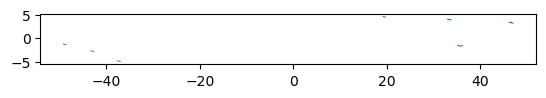

In [226]:
df_val_bursts_tropical_top.plot()

In [227]:
ind_samples = df_slcs_filtered.jpl_burst_id.isin(bursts_with_enough_samples)

tropical_burst_ids = df_val_bursts_tropical_top.jpl_burst_id.unique().tolist()
ind_tropical = df_slcs_filtered.jpl_burst_id.isin(tropical_burst_ids)

df_slcs_final = df_slcs_filtered[ind_samples | ind_tropical].reset_index(drop=True)
print('Final tally of SLCs: ', len(df_slcs_final.fileID.unique()))

Final tally of SLCs:  8960


Let's visualize the sites

In [228]:
df_sites[df_sites.site_id.isin(df_slcs_final.site_id.unique())].change_time

3     2021-11-07
12    2021-10-03
19    2021-11-29
21    2021-12-19
29           NaT
         ...    
286          NaT
287   2021-10-03
291          NaT
293   2022-02-12
295   2022-06-30
Name: change_time, Length: 61, dtype: datetime64[ns]

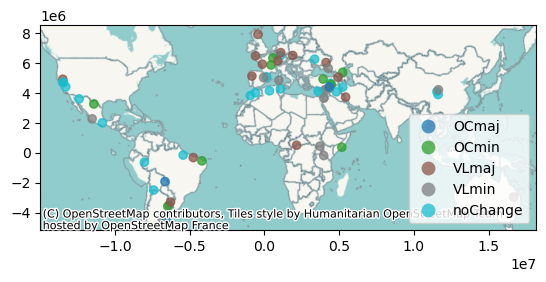

In [229]:
ax = df_sites[df_sites.site_id.isin(df_slcs_final.site_id.unique())].to_crs(epsg=3857).plot(alpha=.75,column='change_label', categorical=True, legend=True)
cx.add_basemap(ax)

We can now plot the SLC frames with a given site.

In [230]:
df_slcs_final.site_id.unique()

array([296, 294, 292, 288, 287, 274, 272, 270, 264, 263, 261, 256, 255,
       251, 250, 249, 248, 235, 228, 226, 224, 222, 212, 206, 205, 204,
       201, 192, 189, 180, 178, 175, 172, 166, 158, 154, 150, 148, 147,
       126, 122, 117, 115, 104,  98,  95,  90,  88,  87,  73,  72,  66,
        55,  50,  40,  34,  30,  22,  20,  13,   4])

<Axes: >

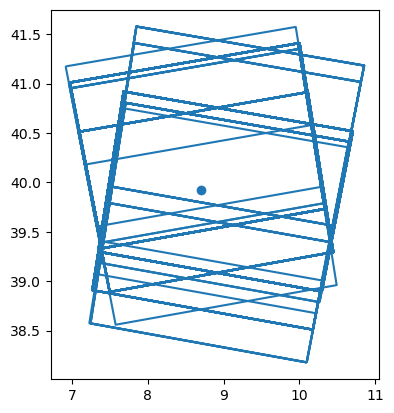

In [231]:
fig, ax = plt.subplots()

site_id_sample = 274
df_slcs_final[df_slcs_final.site_id == site_id_sample].exterior.plot(ax =ax)
df_sites[df_sites.site_id == site_id_sample].plot(ax=ax)

In [330]:
from shapely import from_wkt

PREVIOUS_SLCS = 'slcs_for_processing.csv.zip'

df_prev_data = pd.read_csv(PREVIOUS_SLCS).drop_duplicates(subset='fileID')
df_prev_data['geometry'] = df_prev_data['geometry'].map(from_wkt)
df_prev_data = gpd.GeoDataFrame(df_prev_data, geometry=df_prev_data.geometry, crs=CRS.from_epsg(4326))
df_prev_data.head()

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,sensor,groupID,pgeVersion,fileName,beamModeType,site_id,jpl_burst_id,geometry,date_acquired_str,dist_from_site_to_slc_centroid
0,4.4481,20.2077,2020-10-06 04:24:27+00:00,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,DESCENDING,36,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-10-06 04:24:02+00:00,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,...,C-SAR,S1B_IWDV_0576_0582_023687_036,3.31,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,IW,4,t036_076228_iw3,"POLYGON ((21.16021 3.45474, 21.47518 4.97713, ...",2020-10-06,0.883877
1,4.4236,20.1938,2020-10-12 04:25:12+00:00,S1A_IW_SLC__1SDV_20201012T042442_20201012T0425...,DESCENDING,36,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2020-10-12 04:24:42+00:00,S1A_IW_SLC__1SDV_20201012T042442_20201012T0425...,...,C-SAR,S1A_IWDV_0577_0582_034758_036,3.31,S1A_IW_SLC__1SDV_20201012T042442_20201012T0425...,IW,4,t036_076228_iw3,"POLYGON ((21.11997 3.28893, 21.49321 5.09271, ...",2020-10-12,0.874183
2,4.4486,20.2086,2020-10-18 04:24:27+00:00,S1B_IW_SLC__1SDV_20201018T042402_20201018T0424...,DESCENDING,36,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-10-18 04:24:02+00:00,S1B_IW_SLC__1SDV_20201018T042402_20201018T0424...,...,C-SAR,S1B_IWDV_0576_0582_023862_036,3.31,S1B_IW_SLC__1SDV_20201018T042402_20201018T0424...,IW,4,t036_076228_iw3,"POLYGON ((21.16116 3.45536, 21.47608 4.97751, ...",2020-10-18,0.884746
3,4.4239,20.1944,2020-10-24 04:25:12+00:00,S1A_IW_SLC__1SDV_20201024T042442_20201024T0425...,DESCENDING,36,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2020-10-24 04:24:42+00:00,S1A_IW_SLC__1SDV_20201024T042442_20201024T0425...,...,C-SAR,S1A_IWDV_0577_0583_034933_036,3.31,S1A_IW_SLC__1SDV_20201024T042442_20201024T0425...,IW,4,t036_076228_iw3,"POLYGON ((21.1205 3.2891, 21.4938 5.09313, 19....",2020-10-24,0.874706
4,4.4484,20.2082,2020-10-30 04:24:28+00:00,S1B_IW_SLC__1SDV_20201030T042402_20201030T0424...,DESCENDING,36,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-10-30 04:24:02+00:00,S1B_IW_SLC__1SDV_20201030T042402_20201030T0424...,...,C-SAR,S1B_IWDV_0576_0582_024037_036,3.31,S1B_IW_SLC__1SDV_20201030T042402_20201030T0424...,IW,4,t036_076228_iw3,"POLYGON ((21.16076 3.45513, 21.4757 4.9774, 19...",2020-10-30,0.884370


In [331]:
df_total = pd.concat([df_slcs_final, df_prev_data], axis=0).reset_index(drop=True)
df_total = df_total.drop_duplicates(subset='fileID')
df_total.shape[0], df_prev_data.shape[0]

(10647, 8703)

In [332]:
prev_ids = df_prev_data.fileID.tolist()
df_delta = df_total[~df_total['fileID'].isin(prev_ids)].reset_index(drop=True)
df_delta.shape[0], df_total.shape[0] - df_prev_data.shape[0], len([id_ for id_ in df_total.fileID.tolist() if id_ not in prev_ids])

(1944, 1944, 1944)

In [333]:
print('Total cost of delta assuming .35 per prod: ', df_delta.shape[0] * .35) 

Total cost of delta assuming .35 per prod:  680.4


In [339]:
df_delta.to_parquet(f'delta_slcs_{today}.parquet')

In [340]:
df_total.drop(columns='pgeVersion').to_parquet(f'total_runnning_slcs_{today}.parquet')